In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import pandas as pd
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from torch_geometric.datasets import LastFM

In [2]:
dataset = LastFM('./data/raw/LastFM/')


In [3]:
np.random.seed(1337)
torch.manual_seed(1337)

In [4]:
NUM_USERS = 1892
NUM_MOVIES = 17632
BATCH_SIZE = 64

num_user_features = 1
num_movie_features = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from collections import defaultdict

# loading preprocessed data
path = "./data/raw/LastFM/raw/"

user_features = defaultdict(lambda: torch.tensor(0))
user_sums = defaultdict(lambda: torch.tensor(0))
user_counts = defaultdict(lambda: torch.tensor(0))
with open(path + 'user_user(knn).dat') as f:
    text = f.readlines()
    for line in text:
        u1, u2, w = map(float, line.split())
        user_sums[u1] = user_sums[u1] + w
        user_counts[u1] = user_counts[u1] + 1

for i in user_sums:
    user_features[i] = user_sums[i] / user_counts[i]

movie_features = defaultdict(lambda: torch.tensor(0))
movie_sums = defaultdict(lambda: torch.tensor(0))
movie_counts = defaultdict(lambda: torch.tensor(0))
with open(path + 'artist_artist(knn).dat') as f:
    text = f.readlines()
    for line in text:
        u1, u2, w = map(float, line.split())
        movie_sums[u1] = movie_sums[u1] + w
        movie_counts[u1] = movie_counts[u1] + 1

for i in movie_sums:
    movie_features[i] = movie_sums[i] / movie_counts[i]


In [6]:
dataset[0]

HeteroData(
  user={ num_nodes=1892 },
  artist={ num_nodes=17632 },
  tag={ num_nodes=1088 },
  (user, to, artist)={
    train_neg_edge_index=[2, 33294760],
    val_pos_edge_index=[2, 9283],
    val_neg_edge_index=[2, 9283],
    test_pos_edge_index=[2, 18567],
    test_neg_edge_index=[2, 18567],
    edge_index=[2, 64984],
  },
  (user, to, user)={ edge_index=[2, 25434] },
  (artist, to, user)={ edge_index=[2, 64984] },
  (artist, to, tag)={ edge_index=[2, 23253] },
  (tag, to, artist)={ edge_index=[2, 23253] }
)

In [7]:
edge_index = dataset[0]['user', 'to', 'artist']['edge_index']
train_aua = defaultdict(lambda: np.zeros(shape=(0,3)))
for i in tqdm(edge_index[0].unique()):
    neigbours = torch.where(edge_index[0] == i, edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neigbours)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    mpaths = torch.hstack((comb[:,:1], col, comb[:,1:]))
    for path in mpaths:
        train_aua[int(path[0])] = np.vstack((train_aua[int(path[0])], path))



  0%|          | 0/1892 [00:00<?, ?it/s]

100%|██████████| 1892/1892 [00:35<00:00, 53.49it/s]


In [8]:
train_aua[144]

array([], shape=(0, 3), dtype=float64)

In [9]:
edge_index = dataset[0]['artist', 'to', 'user']['edge_index']
train_uau = defaultdict(lambda: np.zeros(shape=(0,3)))
for i in tqdm(edge_index[0].unique()):
    neigbours = torch.where(edge_index[0] == i, edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neigbours)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    mpaths = torch.hstack((comb[:,:1], col, comb[:,1:]))
    for path in mpaths:
        train_uau[int(path[0])] = np.vstack((train_uau[int(path[0])], path))



100%|██████████| 17632/17632 [01:01<00:00, 286.11it/s] 


In [10]:
edge_index = dataset[0]['user', 'to', 'artist']['test_pos_edge_index']
test_aua = defaultdict(lambda: np.zeros(shape=(0,3)))
for i in tqdm(edge_index[0].unique()):
    neigbours = torch.where(edge_index[0] == i, edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neigbours)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    mpaths = torch.hstack((comb[:,:1], col, comb[:,1:]))
    for path in mpaths:
        test_aua[int(path[0])] = np.vstack((test_aua[int(path[0])], path))



100%|██████████| 1863/1863 [00:03<00:00, 484.51it/s]


In [11]:
edge_index = dataset[0]['user', 'to', 'artist']['test_pos_edge_index']
test_uau = defaultdict(lambda: np.zeros(shape=(0,3)))
for i in tqdm(edge_index[1].unique()):
    neigbours = torch.where(edge_index[1] == i, edge_index, -1)[0].unique()[1:]
    comb = torch.combinations(neigbours)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    mpaths = torch.hstack((comb[:,:1], col, comb[:,1:]))
    for path in mpaths:
        test_uau[int(path[0])] = np.vstack((test_uau[int(path[0])], path))


100%|██████████| 4041/4041 [00:08<00:00, 487.18it/s] 


In [12]:
#TODO : Fix it
train_user_metapaths = train_uau

train_movie_metapaths = train_aua

train_pos = dataset[0]['user', 'to', 'artist']['edge_index']

train_neg = torch.zeros(size=(0, 2))
for i in dataset[0]['user', 'to', 'artist']['train_neg_edge_index'][:,]:
    print(i)
    if i[0] in train_user_metapaths and i[1] in train_movie_metapaths:
        print('===')
        train_neg = torch.cat(train_neg, i)
train_neg = train_neg[:, :train_pos.shape[1]]

tensor([   0,    0,    0,  ..., 1891, 1891, 1891])
tensor([    0,     1,     2,  ..., 17629, 17630, 17631])


In [13]:
train_neg

tensor([], size=(0, 2))

In [263]:

test_user_metapaths = test_uau

test_movie_metapaths = test_aua

test_pos = dataset[0]['user', 'to', 'artist']['test_pos_edge_index']
test_neg = dataset[0]['user', 'to', 'artist']['test_neg_edge_index'][:, :test_pos.shape[1]]

In [264]:
class UserMovieDataset(Dataset):
    '''Dataset for MAGNN training and evaluation'''
    def __init__(self, positives, user_metapaths, movie_metapaths, max_user_size, max_movie_size, negatives=None, benchmark=False):

        self.max_user_size = max_user_size
        self.max_movie_size = max_movie_size

        self.user_metapaths = user_metapaths
        self.movie_metapaths = movie_metapaths
        self.merge_metapaths()

        if not benchmark:
            self.pos = positives.numpy()
            self.neg = negatives.numpy()

            self.data = torch.tensor(np.vstack([self.pos.T, self.neg.T]))
            self.labels = torch.vstack([torch.ones((len(self.pos.T), 1)), torch.zeros((len(self.neg.T), 1))])
        else:
            self.data = torch.tensor(positives[:, :2])
            self.labels = torch.tensor(positives[:, 2])

    def sample_negatives(self):
        self.neg = []
        for i in tqdm(range(len(self.pos)), desc='Sampling negative edges'):
            user_id = np.random.randint(NUM_USERS)
            movie_id = np.random.randint(NUM_MOVIES)
            while (np.array([user_id, movie_id]) not in self.pos and \
                    [user_id, movie_id] not in self.neg) or \
                    len(self.user_metapaths[user_id]) == 0 or \
                    len(self.movie_metapaths[movie_id]) == 0:
                user_id = np.random.randint(NUM_USERS)
                movie_id = np.random.randint(NUM_MOVIES)
            self.neg.append([user_id, movie_id])
        self.neg = np.array(self.neg)

    def merge_metapaths(self):
        for key, val in tqdm(self.user_metapaths.items(), desc='Extracting user metapaths'):
            # print(val[:, 0])
            # print(tuple(i for i in val[:, 0]))
            # print([user_features[i] for i in val[:, 0]])
            if len(self.user_metapaths[key]) > 0:
                self.user_metapaths[key] = [torch.vstack([user_features[i] for i in val[:, 0]])[:self.max_user_size], 
                                            torch.vstack([movie_features[i] for i in val[:, 1]])[:self.max_user_size], 
                                            torch.vstack([user_features[i] for i in val[:, 2]])[:self.max_user_size]]
                while len(self.user_metapaths[key][0]) < self.max_user_size:
                    self.user_metapaths[key][0] = torch.vstack([self.user_metapaths[key][0], torch.zeros_like(self.user_metapaths[key][0][0])])
                    self.user_metapaths[key][1] = torch.vstack([self.user_metapaths[key][1], torch.zeros_like(self.user_metapaths[key][1][0])])
                    self.user_metapaths[key][2] = torch.vstack([self.user_metapaths[key][2], torch.zeros_like(self.user_metapaths[key][2][0])])
                
            
        for key, val in tqdm(self.movie_metapaths.items(), desc='Extracting movie metapaths'):
            if len(self.movie_metapaths[key]) > 0:
                self.movie_metapaths[key] = [torch.vstack([movie_features[i] for i in val[:, 0]])[:self.max_movie_size],
                                            torch.vstack([user_features[i] for i in val[:, 1]])[:self.max_movie_size],
                                            torch.vstack([movie_features[i] for i in val[:, 2]])[:self.max_movie_size]]
                while len(self.movie_metapaths[key][0]) < self.max_movie_size:
                    self.movie_metapaths[key][0] = torch.vstack([self.movie_metapaths[key][0], torch.zeros_like(self.movie_metapaths[key][0][0])])
                    self.movie_metapaths[key][1] = torch.vstack([self.movie_metapaths[key][1], torch.zeros_like(self.movie_metapaths[key][1][0])])
                    self.movie_metapaths[key][2] = torch.vstack([self.movie_metapaths[key][2], torch.zeros_like(self.movie_metapaths[key][2][0])])

    def __getitem__(self, idx):
        user_id, movie_id = self.data[idx]
        return self.data[idx], self.labels[idx], *self.user_metapaths[user_id.item()], *self.movie_metapaths[movie_id.item()]

    def __len__(self):
        return len(self.data)

In [265]:
print('Train Dataset:')
train_dataset = UserMovieDataset(train_pos, train_user_metapaths, train_movie_metapaths, 93, 592, train_neg)
print('Test Dataset:')
test_dataset = UserMovieDataset(test_pos, test_user_metapaths, test_movie_metapaths, 56, 51, test_neg)

Train Dataset:


Extracting movie metapaths:   9%|▉         | 1508/16357 [00:24<03:59, 62.07it/s]


KeyboardInterrupt: 

In [ ]:
train_dataset.data

tensor([[    0,    45],
        [    0,    46],
        [    0,    47],
        ...,
        [    3, 12280],
        [    3, 12281],
        [    3, 12282]])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class GraphAttention(nn.Module):
    '''Attention layer for encoded metapaths'''
    def __init__(self, 
                 hidden_dim,
                 num_heads,
                 dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        weighted, _ = self.attention(queries, keys, values)
        return weighted

class MetapathEncoder(nn.Module):
    '''Inter-metapath aggregator'''
    def __init__(self,
                 in_dim,
                 out_dim, 
                ):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, metapath):
        x = torch.mean(metapath, dim=1)
        return self.fc(x)

class MAGNN(nn.Module):
    '''MAGNN architecture, but simplified for only 1 metapath per node type (due to computing powers limitation)'''
    def __init__(self,
                 num_user_features,
                 num_movie_features,
                 hidden_dim,
                 out_dim,
                 num_heads,
                 dropout,
                 batch_size
                 ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.num_user_features = num_user_features
        self.num_movie_features = num_movie_features

        self.user_feature_encoder = nn.Linear(self.num_user_features, hidden_dim)
        self.movie_feature_encoder = nn.Linear(self.num_movie_features, hidden_dim)

        self.user_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.user_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.movie_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.movie_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.user_node_embedding = nn.Linear(hidden_dim, out_dim)
        self.user_dropout = nn.Dropout(dropout)

        self.movie_node_embedding = nn.Linear(hidden_dim, out_dim, dropout)
        self.movie_dropout = nn.Dropout(dropout)

        self.recommender = nn.Linear(2 * out_dim, 1)

    def forward(self, _, user_metapaths1, user_metapaths2, user_metapaths3, movie_metapaths1, movie_metapaths2, movie_metapaths3):

        user_metapath_isntance = torch.cat([
            self.user_feature_encoder(user_metapaths1),
            self.movie_feature_encoder(user_metapaths2),
            self.user_feature_encoder(user_metapaths3)
        ], dim=1)
        user_aggregated_metapath = F.tanh(self.user_metapath_encoder(user_metapath_isntance))
        user_aggregated_metapath = self.user_metapath_attention(user_aggregated_metapath)

        movie_metapath_isntance = torch.cat([
            self.movie_feature_encoder(movie_metapaths1),
            self.user_feature_encoder(movie_metapaths2),
            self.movie_feature_encoder(movie_metapaths3)
        ], dim=1)
        movie_aggregated_metapath = F.tanh(self.movie_metapath_encoder(movie_metapath_isntance))
        movie_aggregated_metapath = self.movie_metapath_attention(movie_aggregated_metapath)

        user_embed = self.user_dropout(F.sigmoid(self.user_node_embedding(user_aggregated_metapath)))
        movie_embed = self.movie_dropout(F.sigmoid(self.movie_node_embedding(movie_aggregated_metapath)))

        out = self.recommender(torch.cat([user_embed, movie_embed], dim=1))

        return F.sigmoid(out)

In [ ]:
model = MAGNN(num_user_features=num_user_features, 
              num_movie_features=num_movie_features, 
              hidden_dim=128, 
              out_dim=128, 
              num_heads=8, 
              dropout=0.2,
              batch_size=BATCH_SIZE)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-7)

In [ ]:
def train(epoch):

    losses = []
    accs = []

    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        optimizer.zero_grad()

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE
        
        losses.append(loss.item())
        accs.append(acc.cpu())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f'Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}')

    return np.mean(losses)

def validate(epoch):
    losses = []
    accs = []

    model.eval()
    progress_bar = tqdm(test_loader)
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE
        
        losses.append(loss.item())
        accs.append(acc.cpu())

        progress_bar.set_description(f'Validation Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}')
    
    return np.mean(losses)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
EPOCHS = 50
train_losses = []
val_losses = []
best_loss = 1e9
model.to(device)

for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), '../models/best_magnn.pt')

Epoch 0:   0%|          | 0/2031 [00:00<?, ?it/s]

RuntimeError: each element in list of batch should be of equal size

In [ ]:
for i in train_dataset:
    if len(i) != 8:
        print(i[0])

tensor([  1, 144])
tensor([  7, 409])
tensor([ 12, 592])
tensor([ 14, 672])
tensor([ 20, 875])
tensor([ 22, 907])
tensor([ 23, 951])
tensor([  28, 1079])
tensor([  29, 1099])
tensor([  31, 1159])
tensor([  36, 1282])
tensor([  39, 1384])
tensor([  49, 1561])
tensor([  55, 1690])
tensor([  57, 1745])
tensor([  62, 1868])
tensor([  63, 1893])
tensor([  65, 1958])
tensor([  67, 2002])
tensor([  72, 2105])
tensor([  73, 2127])
tensor([  76, 2201])
tensor([  77, 2247])
tensor([  78, 2282])
tensor([  79, 2325])
tensor([  80, 2338])
tensor([  81, 2362])
tensor([  82, 2374])
tensor([  83, 2382])
tensor([  87, 2481])
tensor([  88, 2503])
tensor([  90, 2530])
tensor([  93, 2579])
tensor([  96, 2603])
tensor([  98, 2631])
tensor([ 101, 2713])
tensor([ 102, 2728])
tensor([ 103, 2759])
tensor([ 107, 2813])
tensor([ 111, 2912])
tensor([ 118, 3024])
tensor([ 123, 3102])
tensor([ 126, 3150])
tensor([ 128, 3155])
tensor([ 129, 3162])
tensor([ 134, 3226])
tensor([ 135, 3238])
tensor([ 137, 3275])
tensor

In [ ]:
train_dataset.movie_metapaths[144]

array([], shape=(0, 3), dtype=float64)

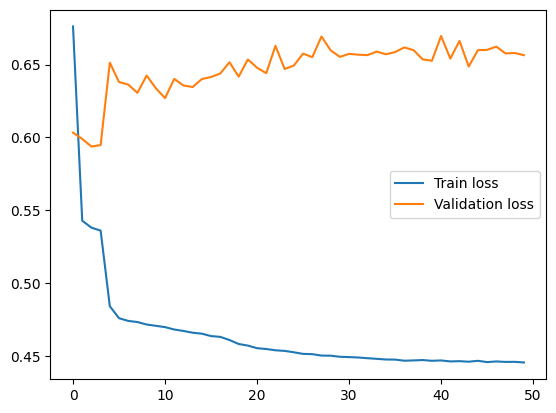

In [ ]:
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.savefig('../reports/figures/losses.png')
plt.show()

In [ ]:
path = '../benchmark/data/'

in_file = open(path + 'user_metapaths.pickle', 'rb')
benchmark_user_metapaths = pickle.load(in_file)
in_file.close()

in_file = open(path + 'movie_metapaths.pickle', 'rb')
benchmark_movie_metapaths = pickle.load(in_file)
in_file.close()

benchmark_data = np.load(path + 'benchmark_dataset.npy')

In [ ]:
benchmark_dataset = UserMovieDataset(benchmark_data, benchmark_user_metapaths, benchmark_movie_metapaths, 100, 41, benchmark=True)

benchmark_loader = DataLoader(benchmark_dataset, batch_size=BATCH_SIZE)

Extracting movie metapaths: 100%|██████████| 1682/1682 [00:01<00:00, 1489.70it/s]


In [ ]:
model = MAGNN(num_user_features=num_user_features, 
              num_movie_features=num_movie_features, 
              hidden_dim=128, 
              out_dim=128, 
              num_heads=8, 
              dropout=0.2,
              batch_size=BATCH_SIZE)
model.load_state_dict(torch.load('../models/best_magnn.pt'))

<All keys matched successfully>

In [ ]:
model.to(device)
model.eval()

maps = []
accs = []

for batch in tqdm(benchmark_loader):
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
        edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

    out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)
    pred = (out > 0.5)
    acc = (pred == label.reshape(-1, 1)).sum() / BATCH_SIZE

    accs.append(acc.cpu())
    maps.append(average_precision_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))

print(f'mAP: {np.mean(maps)}')
print(f'Accuracy: {np.mean(accs)}')

  0%|          | 0/1317 [00:00<?, ?it/s]

100%|██████████| 1317/1317 [00:11<00:00, 113.39it/s]

mAP: 0.6403719166147395
Accuracy: 0.5929669737815857
